<b style="color:#000000;font-size:20px;">MT2021037 - Weather data analysis with Linear Regression</b>
<p style="font-size:17px">Starting with some imports!<p>

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns

<p style="font-size:17px">Helper functions for preprocessing, Outlier and dtype processing.<p>

In [2]:
def delete_outliers(all_data):
    for f in all_data.columns.values:
        #removing data that is 3 times standard deviation away from mean of that column
        index = all_data[np.abs(all_data[f]-all_data[f].mean()) > (3*all_data[f].std())].index
        all_data.drop(index, inplace=True)
        
def preprocess(all_data):
    all_data.drop_duplicates(inplace = True, keep = 'first')
    for f in all_data.columns.values:
        if(all_data[f].dtype == 'O'):
            col_data = all_data[f].to_numpy()
            for i in range(col_data.shape[0]):
                try:
                    col_data[i] = float(col_data[i])
                except ValueError:
                    col_data[i] = np.nan
            all_data[f] = col_data
            del col_data;
            gc.collect();
        #filling null values with mean of the data
        all_data[f].fillna(all_data[f].mean(), inplace = True)
        all_data[f] = all_data[f].astype(np.float32)
        plt.xlabel(f)
        plt.boxplot(all_data[f])
        plt.show()
    delete_outliers(all_data)

<p style="font-size:17px">Loading data from csv file and showing description of each feature.<p>

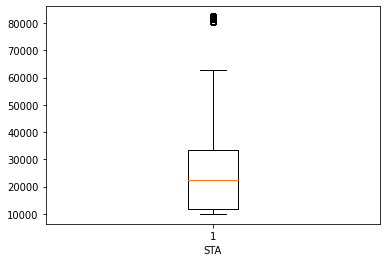

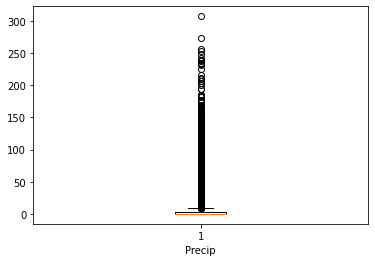

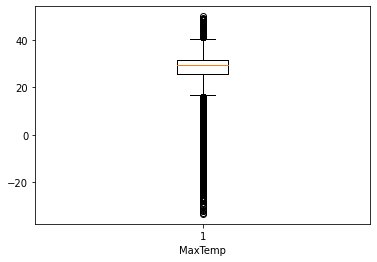

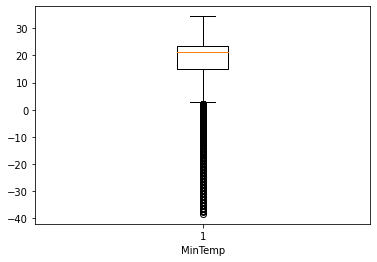

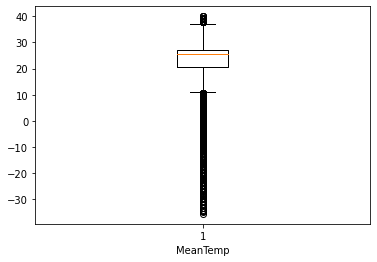

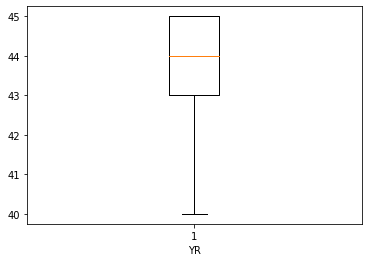

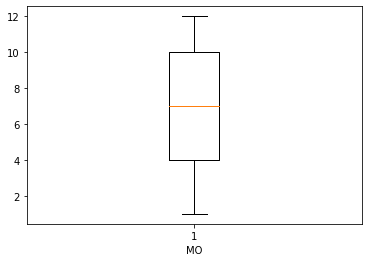

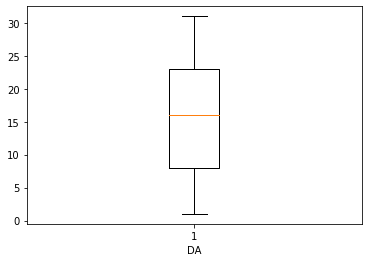

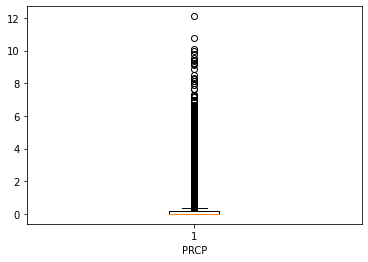

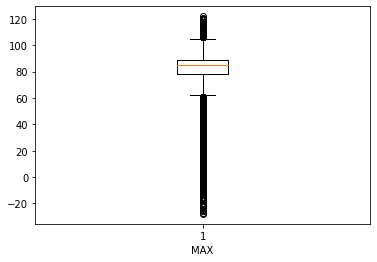

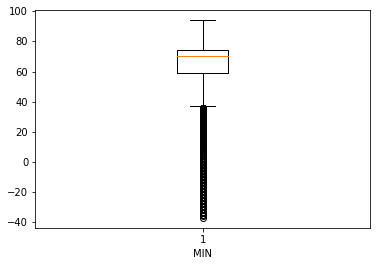

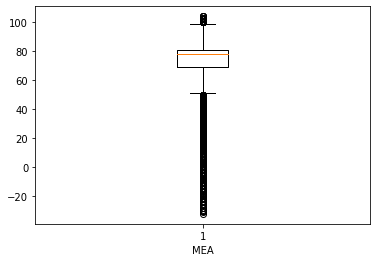

,STA,Precip,MaxTemp,MinTemp,MeanTemp,YR,MO,DA,PRCP,MAX,MIN,MEA
count,103426.000000,103426.000000,103426.000000,103426.000000,103426.000000,103426.000000,103426.000000,103426.000000,103426.000000,103426.000000,103426.000000,103426.000000
mean,30340.619141,1.788722,28.803896,19.234772,24.022203,43.874104,6.742135,15.793098,0.073153,83.847008,66.622589,75.239967
std,21243.585938,3.234394,5.577626,5.815077,5.319395,1.035674,3.385328,8.788745,0.127652,10.039728,10.467139,9.574910
min,10001.000000,0.000000,10.000000,1.111111,7.777778,41.000000,1.000000,1.000000,0.000000,50.000000,34.000000,46.000000
25%,11704.000000,0.000000,26.666666,16.666666,21.666666,43.000000,4.000000,8.000000,0.000000,80.000000,62.000000,71.000000
50%,31101.000000,0.000000,30.000000,21.111111,25.555555,44.000000,7.000000,16.000000,0.000000,86.000000,70.000000,78.000000
75%,34005.000000,3.754205,31.666666,23.333334,27.222221,45.000000,10.000000,23.000000,0.150649,89.000000,74.000000,81.000000
max,82506.000000,18.542000,46.666668,34.444443,39.444443,45.000000,12.000000,31.000000,0.730000,116.000000,94.000000,103.000000


In [3]:
all_data = pd.read_csv("weather.csv")
#permute the data
all_data = all_data.iloc[np.random.permutation(len(all_data))]
preprocess(all_data)
all_data.describe()

In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103426 entries, 27184 to 59792
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   STA       103426 non-null  float32
 1   Precip    103426 non-null  float32
 2   MaxTemp   103426 non-null  float32
 3   MinTemp   103426 non-null  float32
 4   MeanTemp  103426 non-null  float32
 5   YR        103426 non-null  float32
 6   MO        103426 non-null  float32
 7   DA        103426 non-null  float32
 8   PRCP      103426 non-null  float32
 9   MAX       103426 non-null  float32
 10  MIN       103426 non-null  float32
 11  MEA       103426 non-null  float32
dtypes: float32(12)
memory usage: 5.5 MB


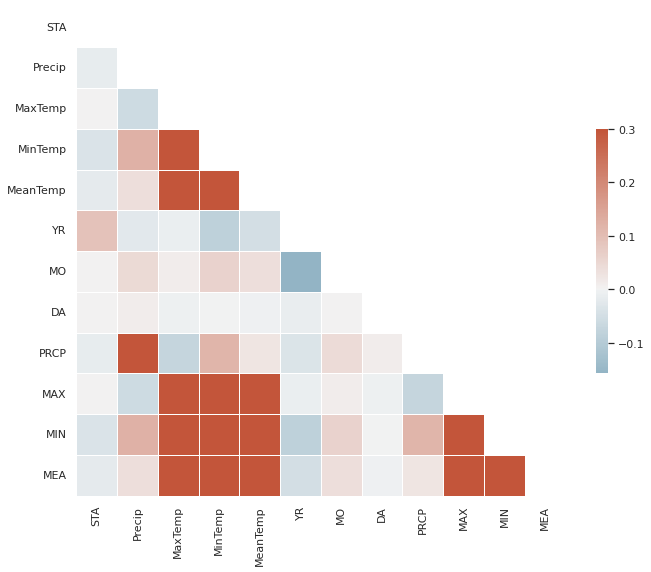

In [5]:
sns.set_theme(style="white")
corr = all_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [6]:
def hess(X_train):
    result = np.zeros((X_train.shape[1], X_train.shape[1]));
    m = X_train.shape[0]
    for i in range(X_train.shape[1]):
        for j in range(X_train.shape[1]):
            result[i][j] = np.dot(X_train[:, j].T, X_train[:, i])/m
    return np.linalg.inv(result);

In [7]:
class LinearRegression():
    #MEAN SQUARED ERROR
    def loss(self,y_true, y_pred):
        ans = (y_true - y_pred)
        ans = np.dot(np.reshape(ans, (1, -1)), np.reshape(ans,(-1, 1)))
        return ans/(y_true.shape[0])

    #GRADIENT CALCULATION
    def grads(self,y_true, y_pred, X):
        cos = (y_pred - y_true)
        cos = np.dot(np.transpose(cos), X)
        return np.transpose(cos/y_true.shape[0])
    
    #CALCULATING HYPOTHESIS
    def predict(self,X, theta):
        return np.dot(X, theta)
    
    #TRAIN HELPER
    def fit(self,X, y_train, learning_rate = 0.1, epochs = 1000,plot = True, hess = False, hess_M = None):
        costs = []
        theta = np.random.randn(X.shape[1],1)
        for i in range(epochs):
            y_preds = self.predict(X, theta)
            cost = self.loss(y_train, y_preds)
            costs.append(cost[0][0])
            if(hess == True):
                theta -= np.dot(hess_M,self.grads(y_train, y_preds, X))
            else:    
                theta -= (learning_rate)*self.grads(y_train, y_preds, X)
        if(plot):
            self.plot(costs)
        return (theta, costs)

    
    def fit_and_visualize_predictions(self,X,y,test_fraction = 0.8, epochs = 100, hess = False, hess_M = None):
        lr = LinearRegression()
        X_train = X[:int(test_fraction * X.shape[0])]
        X_test = X[int(test_fraction*X.shape[0]):]
    
        y_train = y[:int(test_fraction * X.shape[0])]
        y_test = y[int(test_fraction*X.shape[0]):]
        
        theta, costs = lr.fit(X_train, y_train, epochs = epochs, hess = hess, hess_M = hess_M)
        
        y_pred_train = self.predict(X_train,theta)
        y_pred_test = self.predict(X_test,theta)
        
        print("Train Loss : " + str(self.loss(np.reshape(y_train, (-1,1)),y_pred_train)))
        print("Test Loss : " + str(self.loss(np.reshape(y_test, (-1,1)),y_pred_test)))
        
        plt.title("TRAIN PREDICTION PLOT")
        plt.ylabel("Predictions")
        plt.scatter(list(range(100)),y_train[:100],color = '#39add1')
        plt.plot(list(range(100)),y_pred_train[:100], color = '#add139')
        plt.show()
        
        plt.title("TEST PREDICTION PLOT")
        plt.ylabel("Predictions")
        plt.scatter(list(range(100)),y_test[:100],color = '#39add1')
        plt.plot(list(range(100)),y_pred_test[:100], color = '#add139')
        plt.show()
        
    def plot(self,costs):
        x = list(range(len(costs)))
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(x, costs, color='#39add1', linestyle='dashed', marker='o',markerfacecolor='red', markersize=4)
        plt.show()

<p style="font-size:17px">Creating train data and appending the bias with initialisation of all ones.<p>

In [8]:
features = [f for f in all_data.columns.values if not f == "MinTemp"]
X_train = all_data[features]

#NORMALISATION OF DATA USING
X_train = (X_train-X_train.mean())/X_train.std()

#APPENDING BIAS
X_train["bias"] = 1;
X_train = X_train.to_numpy()
y_train = all_data["MinTemp"].to_numpy()

#RESHAPING GROUND TRUTHS WITH (m,1)
y_train = np.reshape(y_train, (-1,1))

TRAINING ON ALL FEATURES


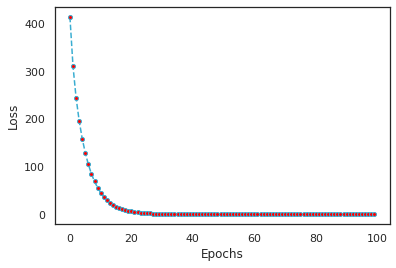

Train Loss : [[0.04961114]]
Test Loss : [[0.04734459]]


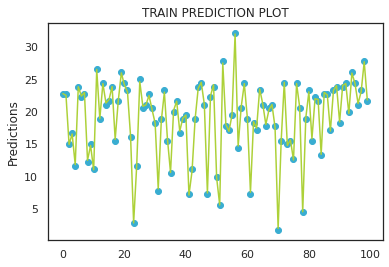

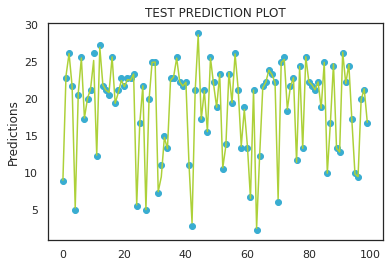



UNIVARIATE STARTS NOW!
TRAINING ON STA


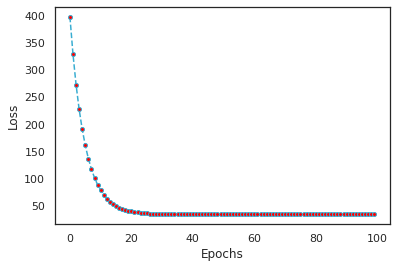

Train Loss : [[33.69479606]]
Test Loss : [[34.03552098]]


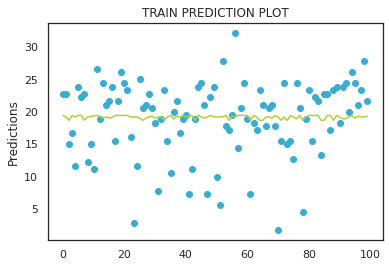

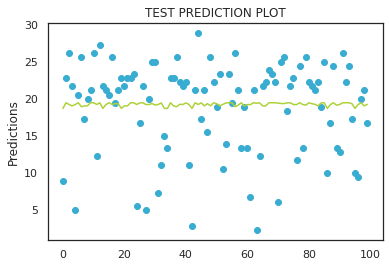

TRAINING ON Precip


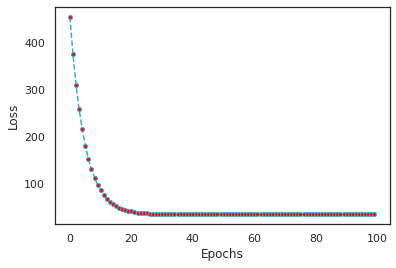

Train Loss : [[33.22609995]]
Test Loss : [[33.61094221]]


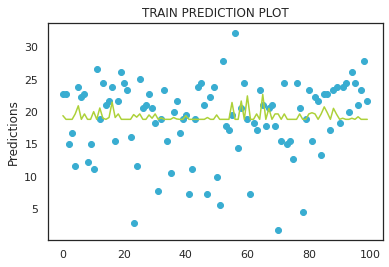

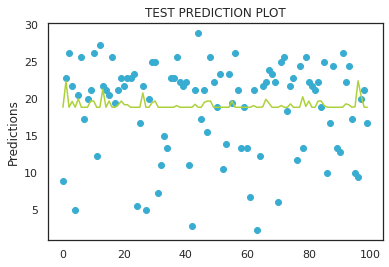

TRAINING ON MaxTemp


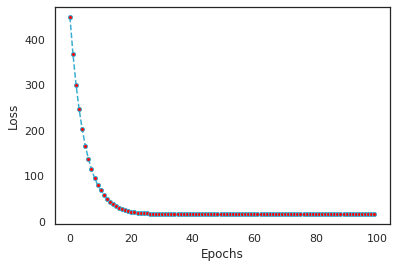

Train Loss : [[15.22802373]]
Test Loss : [[15.31708335]]


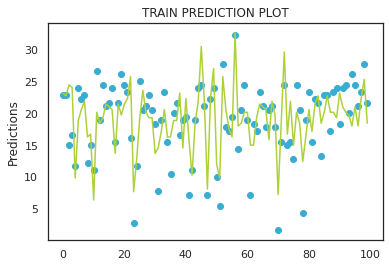

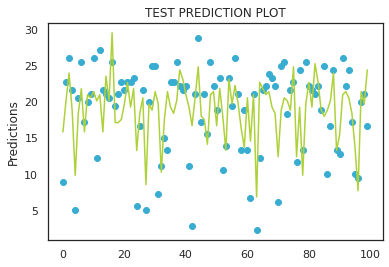

TRAINING ON MeanTemp


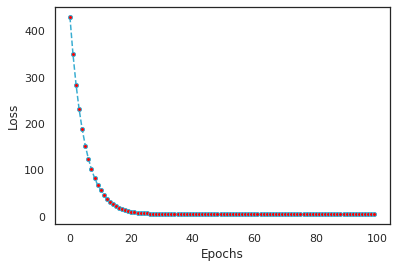

Train Loss : [[4.2561962]]
Test Loss : [[4.26520762]]


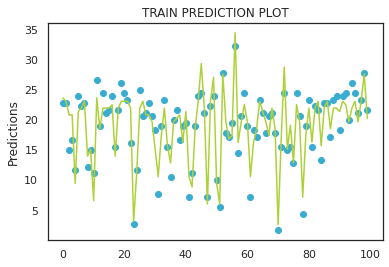

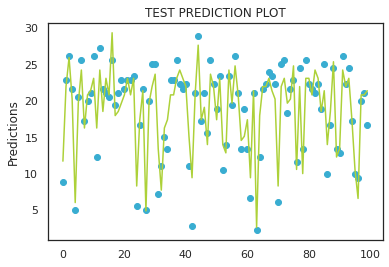

TRAINING ON YR


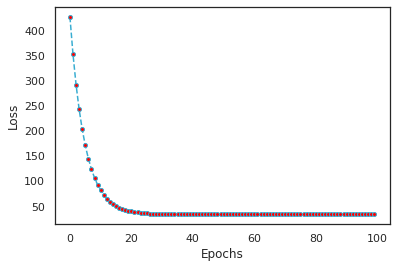

Train Loss : [[33.50442564]]
Test Loss : [[33.85088312]]


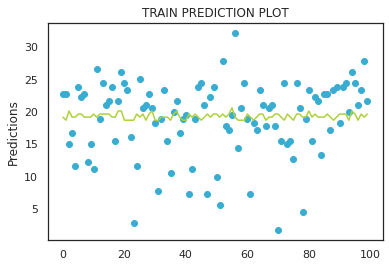

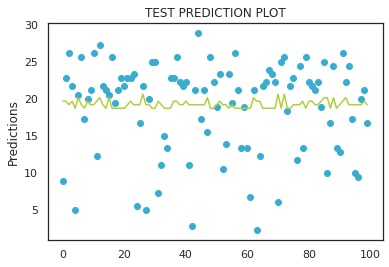

TRAINING ON MO


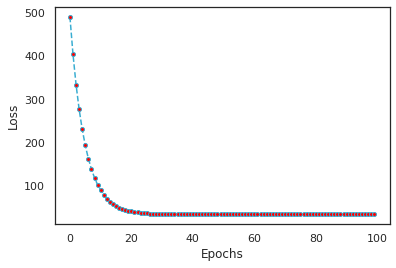

Train Loss : [[33.63227676]]
Test Loss : [[33.95246088]]


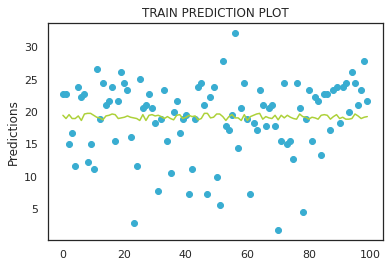

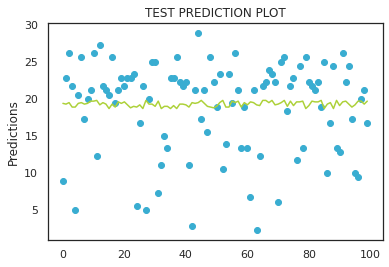

TRAINING ON DA


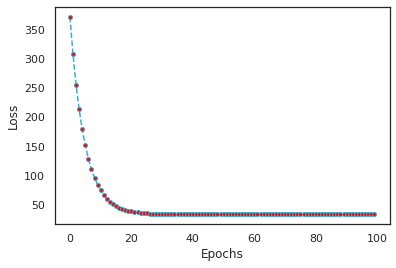

Train Loss : [[33.74675083]]
Test Loss : [[34.08701269]]


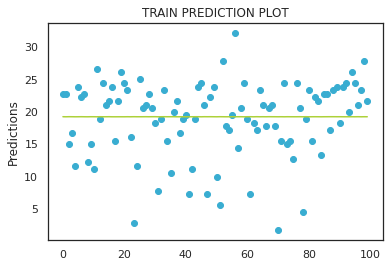

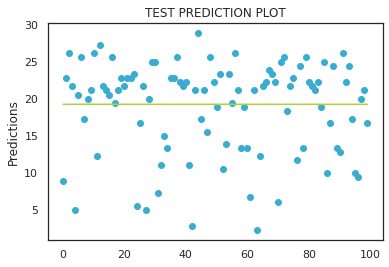

TRAINING ON PRCP


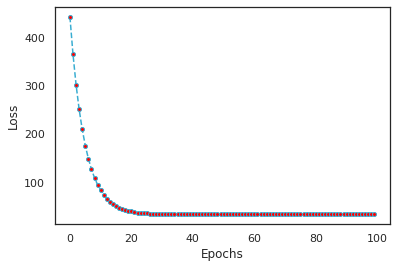

Train Loss : [[33.28139945]]
Test Loss : [[33.66874677]]


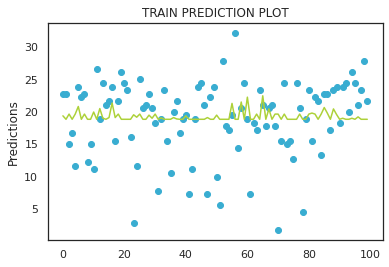

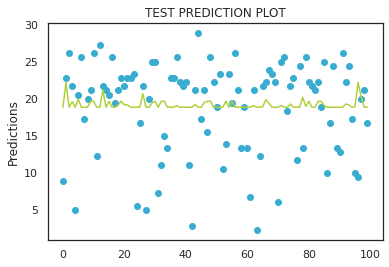

TRAINING ON MAX


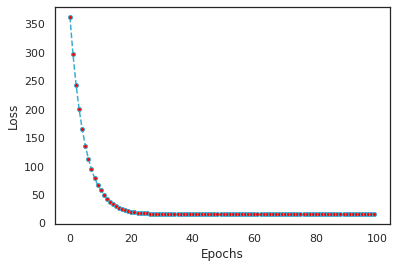

Train Loss : [[15.22802385]]
Test Loss : [[15.3170805]]


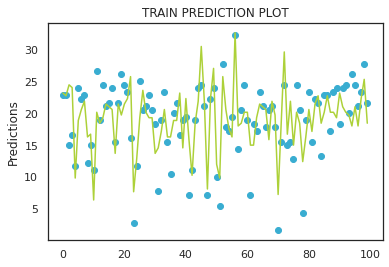

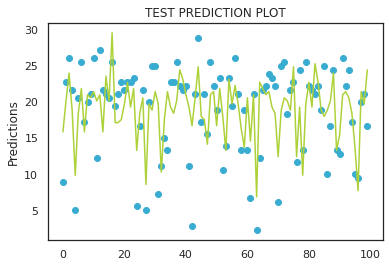

TRAINING ON MIN


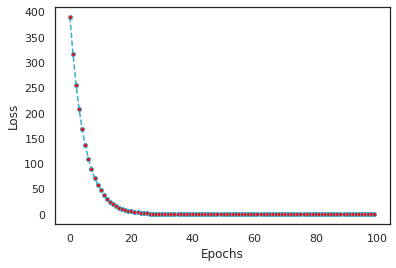

Train Loss : [[2.75385011e-07]]
Test Loss : [[2.75330067e-07]]


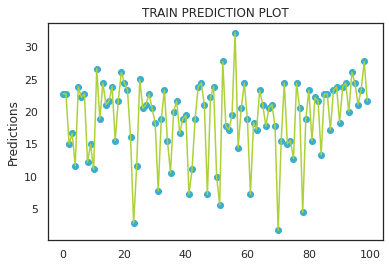

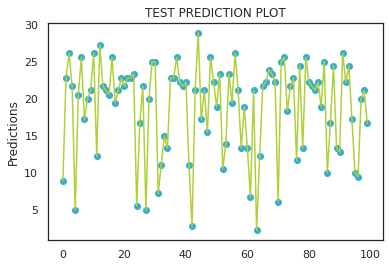

TRAINING ON MEA


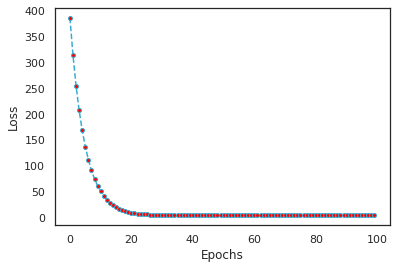

Train Loss : [[4.25619615]]
Test Loss : [[4.26520655]]


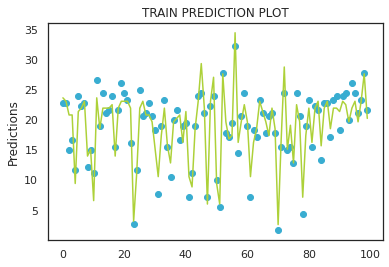

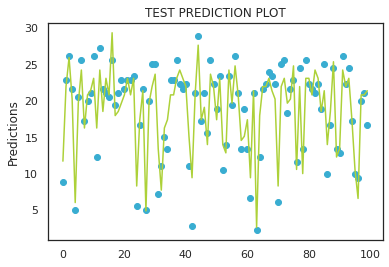

In [9]:
lr = LinearRegression()
print("TRAINING ON ALL FEATURES")
lr.fit_and_visualize_predictions(X_train, y_train)
print();
print();
print("UNIVARIATE STARTS NOW!")
columns = [col for col in features if not col == "bias"]
all_data["bias"] = 1;
for col in columns:
    print("TRAINING ON " + str(col))
    x_train = all_data[["bias",col]].copy();
    x_train[col] = (x_train[col] - x_train[col].mean())/x_train[col].std()
    x_train = x_train.values
    lr.fit_and_visualize_predictions(x_train, y_train);
    plt.show()

<b style="color:#000000;font-size:20px;">NEWTON'S METHOD FOR WEATHER DATA ANALYSIS</b>

TRAINING ON ALL FEATURES


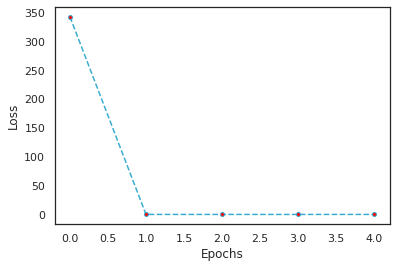

Train Loss : [[2.16831922e-08]]
Test Loss : [[2.14311105e-08]]


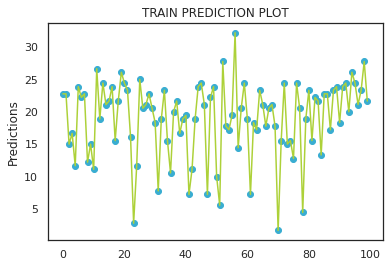

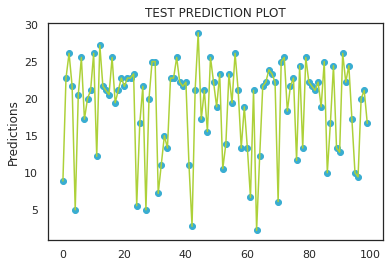



UNIVARIATE STARTS NOW!
TRAINING ON STA


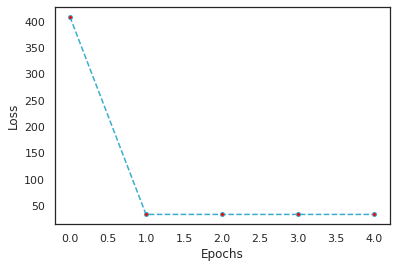

Train Loss : [[33.6947958]]
Test Loss : [[34.03553559]]


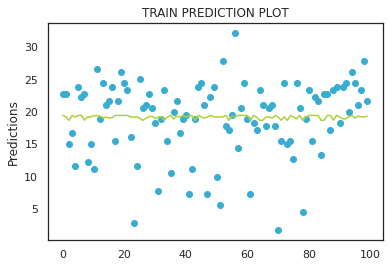

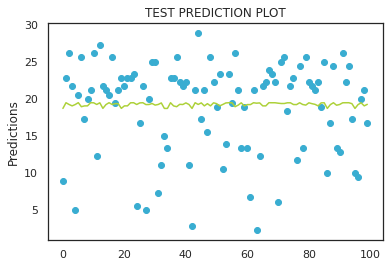

TRAINING ON Precip


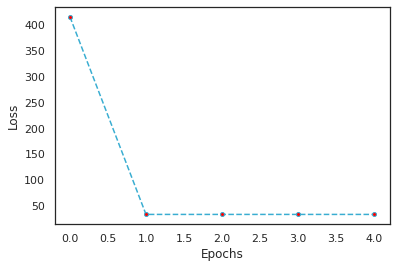

Train Loss : [[33.22609965]]
Test Loss : [[33.61095191]]


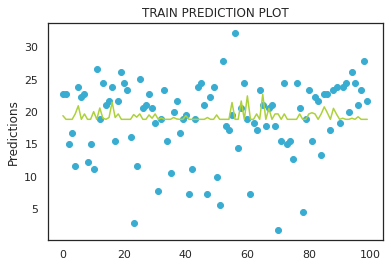

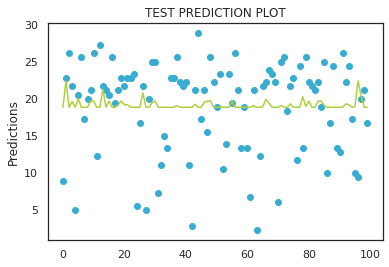

TRAINING ON MaxTemp


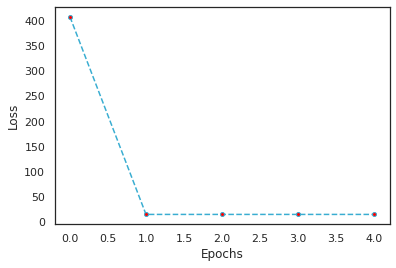

Train Loss : [[15.22802342]]
Test Loss : [[15.31706009]]


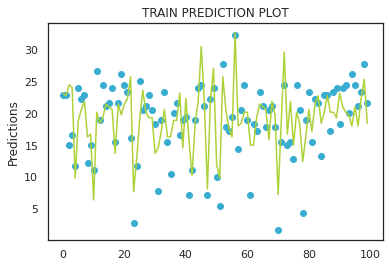

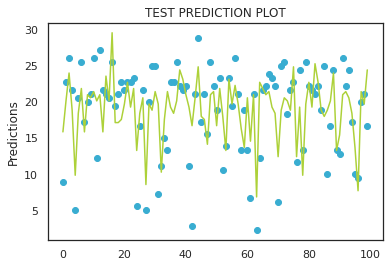

TRAINING ON MeanTemp


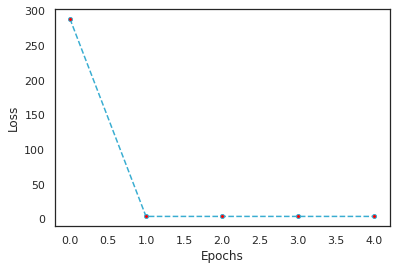

Train Loss : [[4.2561959]]
Test Loss : [[4.26518821]]


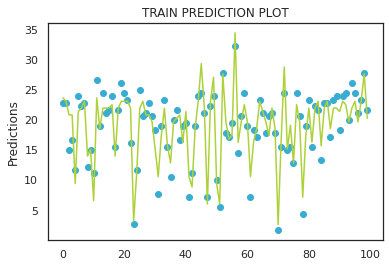

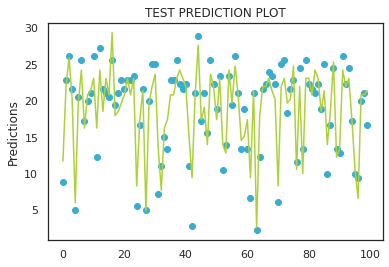

TRAINING ON YR


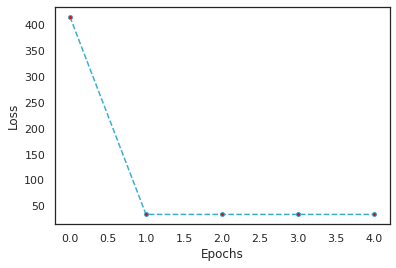

Train Loss : [[33.50442536]]
Test Loss : [[33.85090047]]


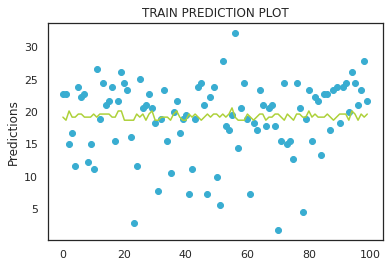

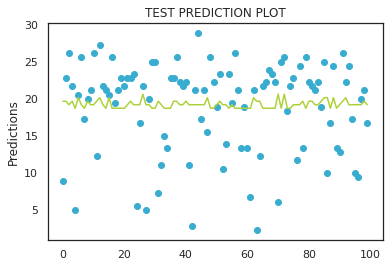

TRAINING ON MO


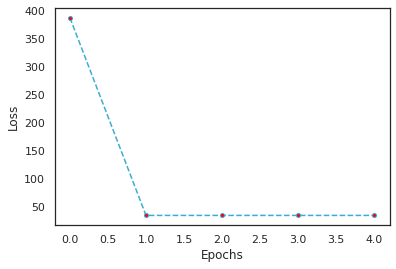

Train Loss : [[33.63227643]]
Test Loss : [[33.95247279]]


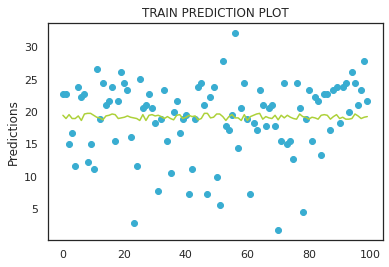

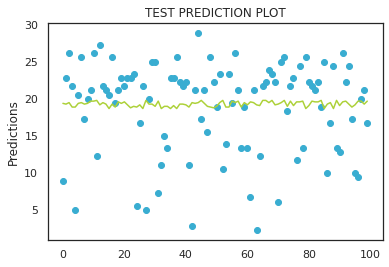

TRAINING ON DA


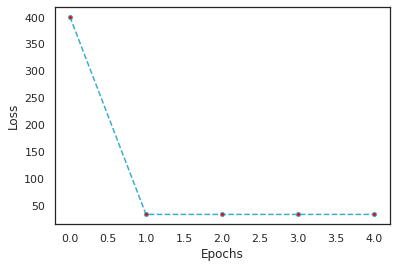

Train Loss : [[33.74675059]]
Test Loss : [[34.08702453]]


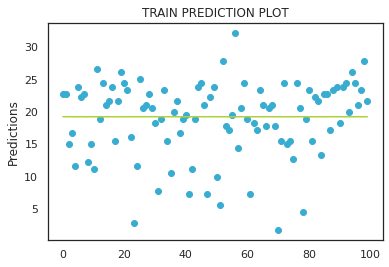

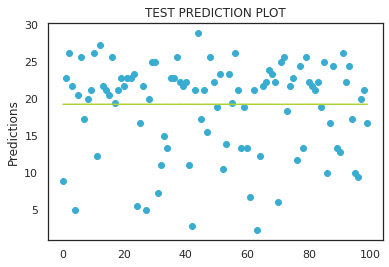

TRAINING ON PRCP


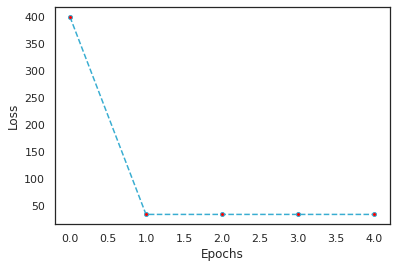

Train Loss : [[33.28139916]]
Test Loss : [[33.66875484]]


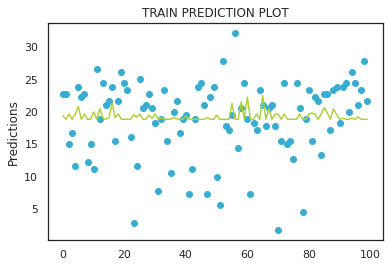

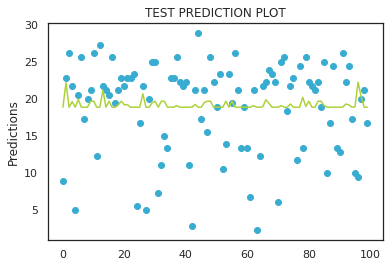

TRAINING ON MAX


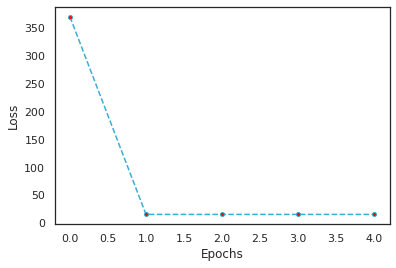

Train Loss : [[15.2280236]]
Test Loss : [[15.31706029]]


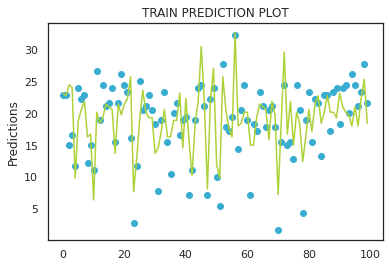

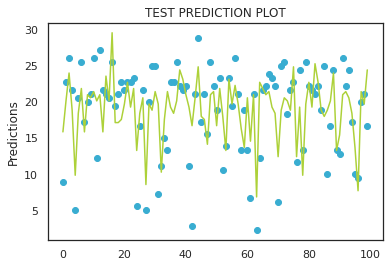

TRAINING ON MIN


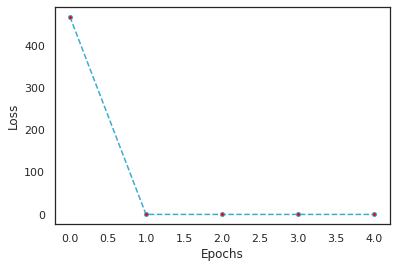

Train Loss : [[2.44701442e-13]]
Test Loss : [[2.41175882e-13]]


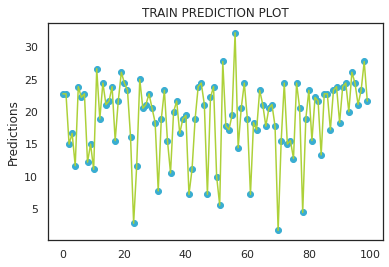

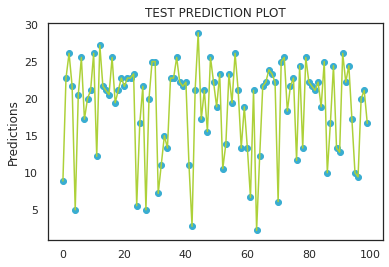

TRAINING ON MEA


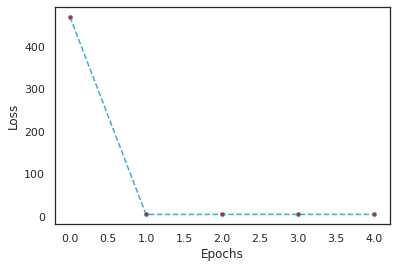

Train Loss : [[4.25619589]]
Test Loss : [[4.26518818]]


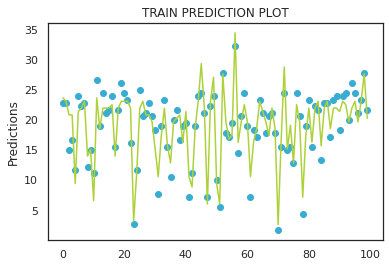

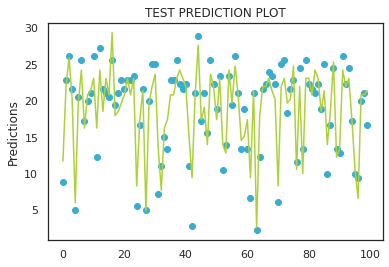

In [10]:
lr = LinearRegression()
print("TRAINING ON ALL FEATURES")
lr.fit_and_visualize_predictions(X_train, y_train, epochs = 5,hess = True, hess_M = hess(X_train));
print();
print();
print("UNIVARIATE STARTS NOW!")
columns = [col for col in features if not col == "bias"]
all_data["bias"] = 1;
for col in columns:
    print("TRAINING ON " + str(col))
    x_train = all_data[["bias",col]].copy();
    x_train[col] = (x_train[col] - x_train[col].mean())/x_train[col].std()
    x_train = x_train.values
    lr.fit_and_visualize_predictions(x_train, y_train, epochs = 5,hess = True, hess_M = hess(x_train));
    plt.show()

<b style="color:#000000;font-size:20px;">Closed form solution</b>

In [11]:
class ClosedFormRegressor:
    def fit(self,X, y):
        m = X.shape[0]
        y = y.reshape(m,1)
        theta = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
        return theta
    
    def loss(self,y_true, y_pred):
        ans = (y_true - y_pred)
        ans = np.dot(np.reshape(ans, (1, -1)), np.reshape(ans,(-1, 1)))
        return ans/(y_true.shape[0])
    
    def predict(self,X, theta):
        return np.dot(X, theta)
    
    def fit_and_visualize_predictions(self,X,y,test_fraction = 0.8):
        X_train = X[:int(test_fraction * X.shape[0])]
        X_test = X[int(test_fraction*X.shape[0]):]
    
        y_train = y[:int(test_fraction * X.shape[0])]
        y_test = y[int(test_fraction*X.shape[0]):]
        
        theta = self.fit(X_train, y_train)
        
        y_pred_train = self.predict(X_train,theta)
        y_pred_test = self.predict(X_test,theta)
        
        print("Train Loss : " + str(self.loss(np.reshape(y_train, (-1,1)),y_pred_train)))
        print("Test Loss : " + str(self.loss(np.reshape(y_test, (-1,1)),y_pred_test)))
        
        plt.title("TRAIN PREDICTION PLOT")
        plt.ylabel("Predictions")
        plt.scatter(list(range(100)),y_train[:100],color = '#39add1')
        plt.plot(list(range(100)),y_pred_train[:100], color = '#add139')
        plt.show()
        
        plt.title("TEST PREDICTION PLOT")
        plt.ylabel("Predictions")
        plt.scatter(list(range(100)),y_test[:100],color = '#39add1')
        plt.plot(list(range(100)),y_pred_test[:100], color = '#add139')
        plt.show()

TRAINING ON ALL FEATURES
Train Loss : [[0.00271391]]
Test Loss : [[0.00273055]]


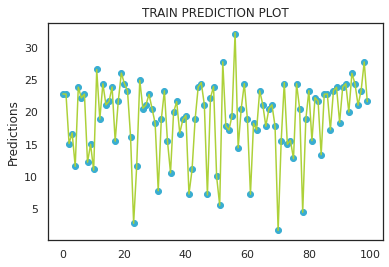

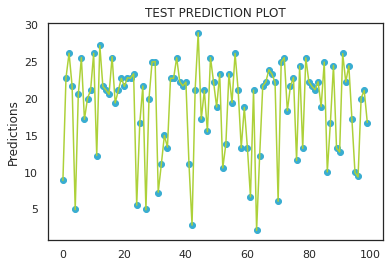



UNIVARIATE STARTS NOW!
TRAINING ON STA
Train Loss : [[33.6947958]]
Test Loss : [[34.03553559]]


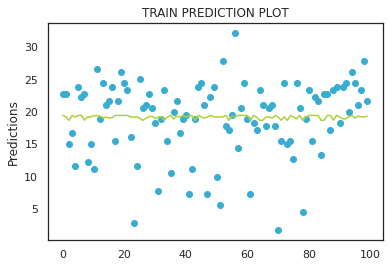

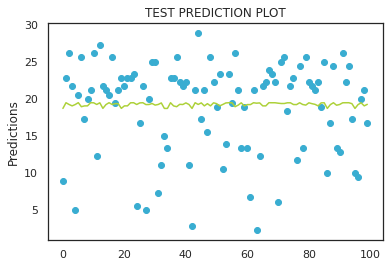

TRAINING ON Precip
Train Loss : [[33.22609965]]
Test Loss : [[33.61095191]]


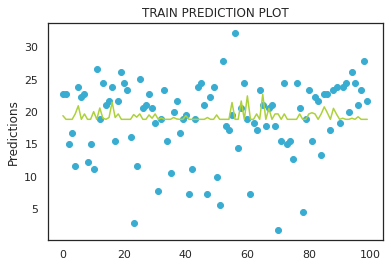

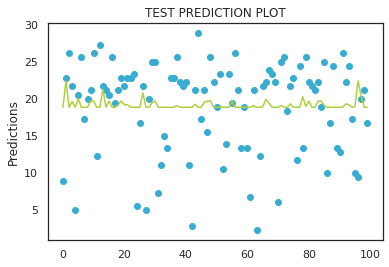

TRAINING ON MaxTemp
Train Loss : [[15.22802342]]
Test Loss : [[15.31706009]]


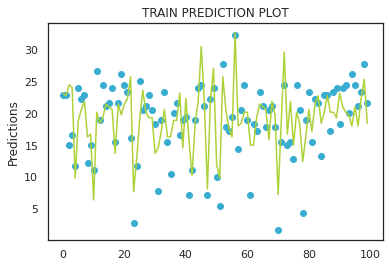

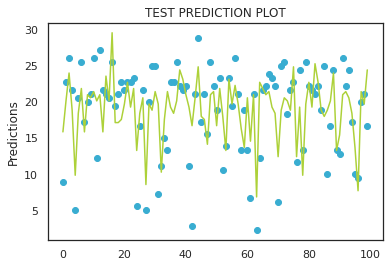

TRAINING ON MeanTemp
Train Loss : [[4.2561959]]
Test Loss : [[4.26518821]]


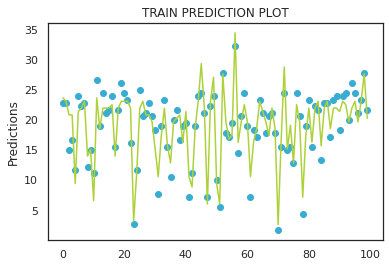

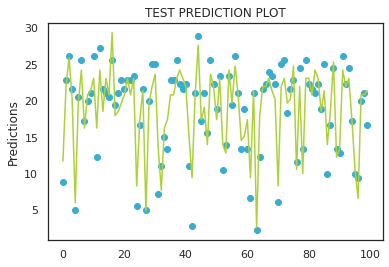

TRAINING ON YR
Train Loss : [[33.50442536]]
Test Loss : [[33.85090047]]


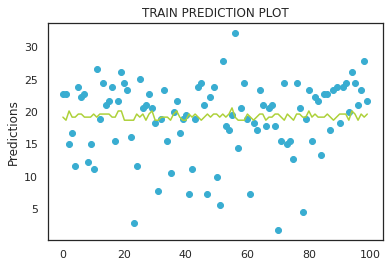

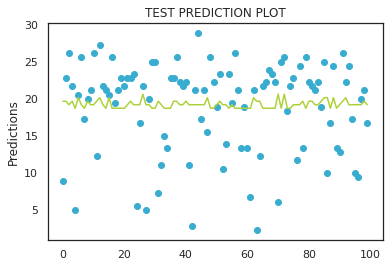

TRAINING ON MO
Train Loss : [[33.63227643]]
Test Loss : [[33.95247279]]


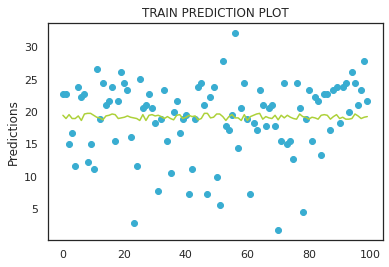

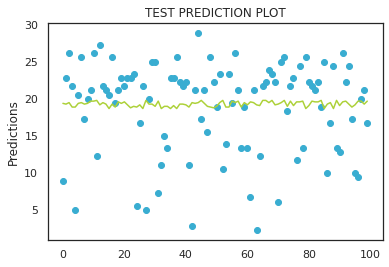

TRAINING ON DA
Train Loss : [[33.74675059]]
Test Loss : [[34.08702453]]


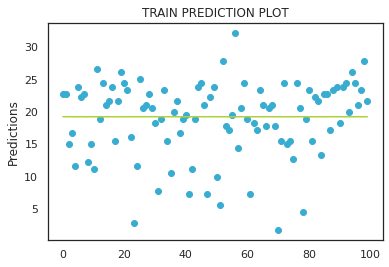

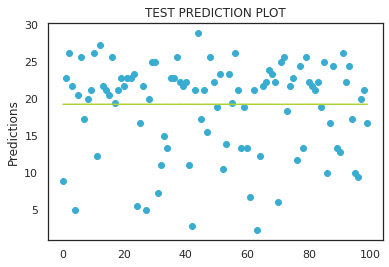

TRAINING ON PRCP
Train Loss : [[33.28139916]]
Test Loss : [[33.66875484]]


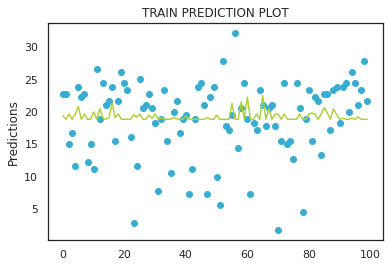

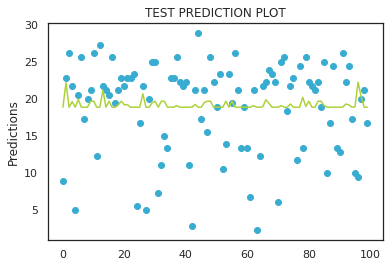

TRAINING ON MAX
Train Loss : [[15.2280236]]
Test Loss : [[15.31706029]]


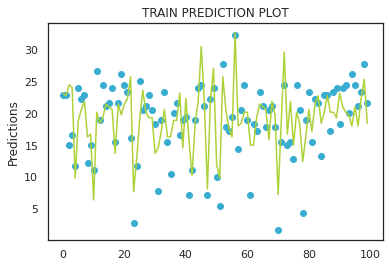

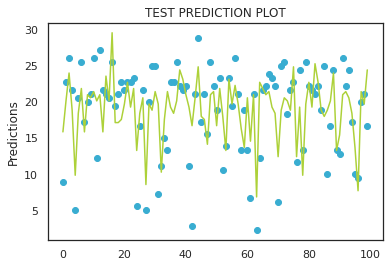

TRAINING ON MIN
Train Loss : [[2.44701442e-13]]
Test Loss : [[2.41175882e-13]]


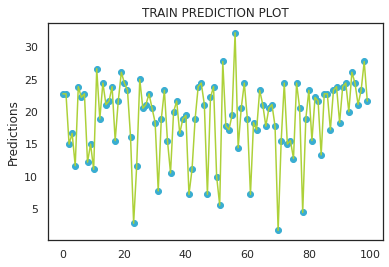

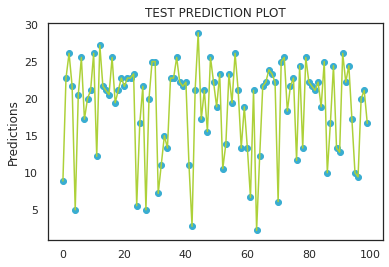

TRAINING ON MEA
Train Loss : [[4.25619589]]
Test Loss : [[4.26518818]]


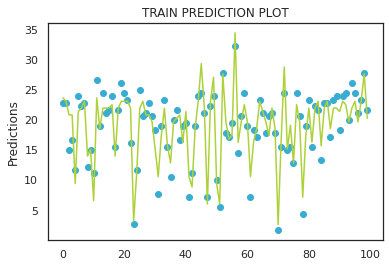

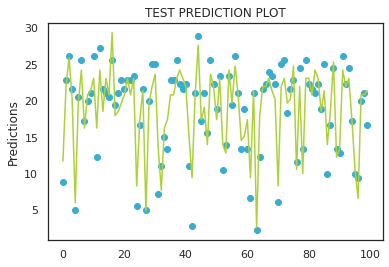

In [12]:

cr = ClosedFormRegressor()
print("TRAINING ON ALL FEATURES")
cr.fit_and_visualize_predictions(X_train, np.reshape(y_train, (-1,)))
print();
print();
print("UNIVARIATE STARTS NOW!")
columns = [col for col in features if not col == "bias"]
all_data["bias"] = 1;
for col in columns:
    print("TRAINING ON " + str(col))
    x_train = all_data[["bias",col]].copy();
    x_train[col] = (x_train[col] - x_train[col].mean())/x_train[col].std()
    x_train = x_train.values
    cr.fit_and_visualize_predictions(x_train, np.reshape(y_train, (-1,)))
    plt.show()